In [10]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import string


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable


from torchvision.io import read_image
from torchvision import transforms
from torchvision import models


In [3]:
src_dir = '/Users/suchetha/Downloads/samples'
img_paths = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg'))]
print("Total no of images in dataset:\t", len(img_paths))

Total no of images in dataset:	 1070


In [403]:
# labels_list = [img_path.split('.')[0] for img_path in img_paths]

# # Get count of each unique char
# char_counts = {}
# for label in labels_list:
#     for char in label:
#         if char not in char_counts:
#             char_counts[char] = 1
#         else:
#             char_counts[char] += 1
            
# # Sort by character
# char_counts = sorted(char_counts.items())
# print(char_counts)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # To supress futurewarning from pandas

# Labels
annotations_df = pd.DataFrame(columns=['image', 'label'])
for image in img_paths:
    annotations_df = annotations_df.append({"image": image, "label": image.split('.')[0]}, ignore_index=True)
    
annotations_df.to_csv("annotations_file.csv")

In [11]:
encoding_dict = {}
i = 0
for character in string.ascii_letters.lower()[:26]:
    encoding_dict[character] = i
    i=i+1
for num in [str(j) for j in range(10)]:
    encoding_dict[num] = i
    i=i+1
    
decoding_dict = {v: k for k, v in encoding_dict.items()}

In [178]:
def decode_pred(model_out):
    one = torch.argmax(model_out[:, 0:36], axis=1)
    two = torch.argmax(model_out[:, 36:36*2], axis=1)
    three = torch.argmax(model_out[:, 36*2:36*3], axis=1)
    four = torch.argmax(model_out[:, 36*3:36*4], axis=1)
    five = torch.argmax(model_out[:, 36*4:36*5], axis=1)
    
    prediction_values = torch.transpose(torch.vstack((one, two, three, four, five)),0,1).tolist()
    
    pred_val = []
    for row in prediction_values:
        pred_val_temp = []
        for value in row:
            pred_val_temp.append(decoding_dict[value])
        pred_val.append(pred_val_temp)

        
    return pred_val

In [146]:
def decode_truth(model_out):
    one = labels[:, 0:36]
    two = labels[:, 36:36*2]
    three = labels[:, 36*2:36*3]
    four = labels[:, 36*3:36*4]
    five = labels[:, 36*4:36*5]

    decoded_labels = []
    for batch_ in range(len(one)):
        decoded_ = []
        decoded_.append(decoding_dict[(one[batch_] == 1).nonzero(as_tuple=True)[0].item()]) # get index of 1 
        decoded_.append(decoding_dict[(two[batch_] == 1).nonzero(as_tuple=True)[0].item()])
        decoded_.append(decoding_dict[(three[batch_] == 1).nonzero(as_tuple=True)[0].item()])
        decoded_.append(decoding_dict[(four[batch_] == 1).nonzero(as_tuple=True)[0].item()])
        decoded_.append(decoding_dict[(five[batch_] == 1).nonzero(as_tuple=True)[0].item()])
        decoded_labels.append(decoded_)

    return decoded_labels

## Data Loader

In [19]:
class CaptchaDataset(Dataset):
    def __init__(self,  img_dir, annotations_file, transform, encoding_dict):
        self.img_dir = img_dir
        self.encoding_dict = encoding_dict
        self.img_labels = pd.read_csv(annotations_file)
        self.transform=transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        image = image[0:3, :, :] # reduce to 3 channel
        # One hot encode the targets
        # label = fncnb, ohc_label = matrix of dim (36, 5) 
        label = self.img_labels.iloc[idx, 2]
        y = torch.zeros(36, 5)  
        for i in range(len(label)):
            
            y[self.encoding_dict[label[i]], i] = 1
        # y = torch.argmax(y, dim=0) #argmax along the column
        # Flatten along the columns to retain the position information. -> 36*5 = 180
        y = y.transpose(1, 0).flatten()
        if self.transform:
            image = self.transform(image)
        return image, y
        
    def __len__(self):
        return len(self.img_labels)

In [20]:
img_dir = '/Users/suchetha/Downloads/Samples'
annotations_file = '/Users/suchetha/annotations_file.csv'

transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
captcha_dataset = CaptchaDataset(img_dir, annotations_file, transform=transform, encoding_dict=encoding_dict)

Feature batch shape: torch.Size([5, 3, 50, 200])
Labels batch shape: torch.Size([5, 180])
----------



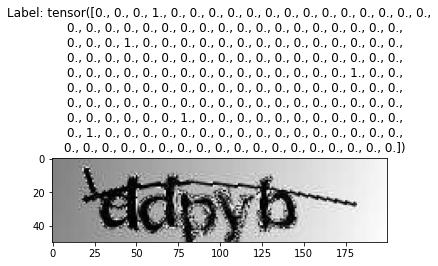

In [142]:
dataset_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size = 5, shuffle = True, num_workers=0)

features, labels = next(iter(dataset_loader))

print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
print("----------\n")

img = features[0].squeeze()
label = labels[0]
plt.imshow(transforms.ToPILImage()(img))
plt.title(f"Label: {label}")
plt.show()

## Train & Test data

In [206]:
validation_split = 0.2
shuffle_dataset = True
random_seed = 7
batch_size = 50

dataset_size = len(captcha_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size=batch_size, sampler=valid_sampler)

In [23]:
len(train_indices)

856

## Network

### Simple Net

In [216]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 47, 480)
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 180)

    def forward(self, x):
        # print("x", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print("x", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print("x", x.size())
        x = x.view(-1, 16 * 9 * 47)
        # print("x", x.size())
        x = F.relu(self.fc1(x))
        # print("x", x.size())
        x = F.relu(self.fc2(x))
        # print("x", x.size())
        x = self.fc3(x)
        
        # print("x", x.size())
        # print("----------")
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Training

In [218]:
for epoch in range(20):  
    total_train = 0
    correct_train = 0
    for batch_idx, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            labels_decoded_train = decode_truth(labels)
            output_decoded_train = decode_pred(outputs) 
            for i in range(len(labels_decoded_train)):
                truth_train = ''.join(labels_decoded_train[i])
                pred_train = ''.join(output_decoded_train[i])
                # print("Pred: ", pred_train, ", Truth:", truth_train)
                if truth_train==pred_train:
                    correct_train += 1
        total_train += labels.size(0)
        
        print('eopch:', epoch+1, 'batch_idx:', batch_idx+1, 'loss:', loss.item())
    print('epoch:', epoch+1, 'Accuracy:', (correct_train/total_train)*100)
    print('--------------------')
        


eopch: 1 batch_idx: 1 loss: 25.96772003173828
eopch: 1 batch_idx: 2 loss: 25.859970092773438
eopch: 1 batch_idx: 3 loss: 25.25299644470215
eopch: 1 batch_idx: 4 loss: 24.978294372558594
eopch: 1 batch_idx: 5 loss: 24.501968383789062
eopch: 1 batch_idx: 6 loss: 24.547449111938477
eopch: 1 batch_idx: 7 loss: 23.810749053955078
eopch: 1 batch_idx: 8 loss: 23.58267593383789
eopch: 1 batch_idx: 9 loss: 23.581621170043945
eopch: 1 batch_idx: 10 loss: 23.49077796936035
eopch: 1 batch_idx: 11 loss: 23.414283752441406
eopch: 1 batch_idx: 12 loss: 23.090444564819336
eopch: 1 batch_idx: 13 loss: 23.262489318847656
eopch: 1 batch_idx: 14 loss: 22.878904342651367
eopch: 1 batch_idx: 15 loss: 23.0262451171875
eopch: 1 batch_idx: 16 loss: 22.791353225708008
eopch: 1 batch_idx: 17 loss: 22.980520248413086
eopch: 1 batch_idx: 18 loss: 22.908065795898438
epoch: 1 Accuracy: 0.0
--------------------
eopch: 2 batch_idx: 1 loss: 22.512683868408203
eopch: 2 batch_idx: 2 loss: 22.541948318481445
eopch: 2 batc

## Test

In [219]:
correct = 0
total = 0
i1 = 0

net.eval()
correct = 0
l = []
with torch.no_grad():
    for data in validation_loader:
        i1 += 1
        images, labels = data
        outputs = net(Variable(images))
        labels_decoded = decode_truth(labels)
        outputs_decoded = decode(outputs)  
        for i in range(len(labels_decoded)):
            truth = ''.join(labels_decoded[i])
            pred = ''.join(outputs_decoded[i])
            # print("Pred: ", pred, ", Truth:", truth)
            if truth==pred:
                correct += 1
        total += labels.size(0)
    # if i1 == 1:
    #     break

In [220]:
print((correct/total)*100)

16.355140186915886
